In [1]:
import numpy as np
import astropy.units as u
import astropy.constants as const
from fargocpt import Loader

output_dir = "../../output/tests/self_gravity/out"
ld = Loader(output_dir)

In [2]:
ld.gas.grid

   Grid
| radi: 0.91925570303594 1.49598e+13 cm ... 13.597957520108286 1.49598e+13 cm
| phii: 0.0 ... 6.283185307179586
| Nrad: 32
| Naz: 64
| Spacing: Logarithmic
____________________

## Goal

Compare the self-gravity accelerations from the SG module in FargoCPT to reference values.

## Intermediate Steps

1. Get a meshgrid with the input to the SG module.
2. Generate the smoothing length for each cell according to the Moldenhauer formulation.
3. Compute the sg accelerations via direct summation in cartesian coordinates using $\vec{a} = \int\text{d}\phi \int\text{d}r' \frac{\text{G} m(r')}{d^2 + \epsilon^2} \frac{\vec{d}}{d}$ with $\vec{d} = \vec{r} - \vec{r'}$.
4. Convert acceleration to polar coordinates.
5. Compare

## Data on meshgrid

In [3]:
R, PHI, Sigma = ld.gas.vars2D.get("Sigma", 0, grid_for_plot=False)

In [4]:
Rplot, PHIplot = ld.gas.vars2D.meshgrid_plot("Sigma")

Text(0, 0.5, 'Sigma [g/cm2]')

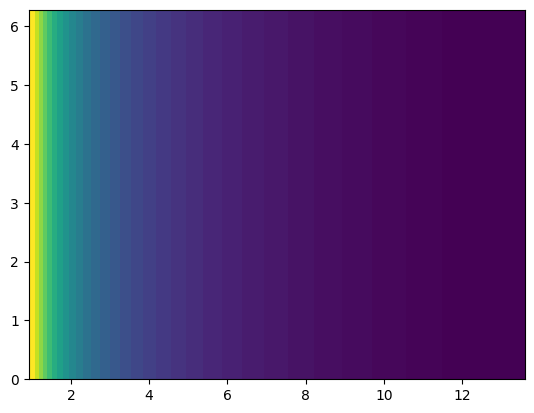

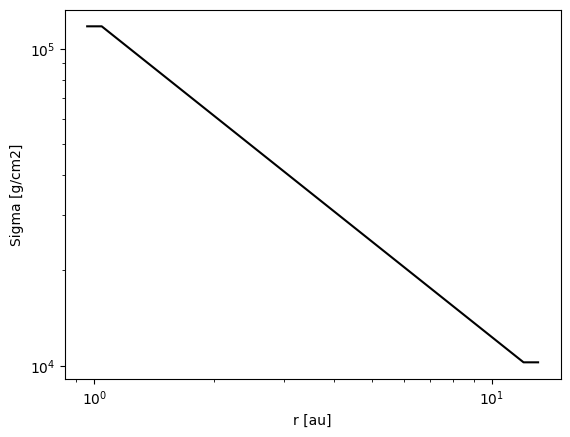

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.pcolormesh(Rplot.to_value("au"), PHIplot, Sigma.to_value("g/cm2"))

fig, ax = plt.subplots()
ax.plot(R[:,0].to_value("au"), Sigma[:,0].to_value("g/cm2"), color="k")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("r [au]")
ax.set_ylabel("Sigma [g/cm2]")


Looks like a powerlaw disk and the results are plausible.

## 2. Define a function for the smoothing length according to the Moldenhauer formulation.

The smoothing length is 

$\epsilon^2_\mathrm{sg} (\vec{r}, \vec{r}^\prime) = \chi^2 r r^\prime + \lambda^2 (r - r^\prime)^2$

with $\chi(h) = -0.7543 h^2 + 0.6472 h$ 

and $\lambda(h) = 0.4571 h + 0.6737 h^2$


In the code
```c++
lambda_sq = std::pow(0.4571 * aspect_ratio + 0.6737 * std::sqrt(aspect_ratio), 2);
chi_sq = std::pow((-0.7543 * aspect_ratio + 0.6472) * aspect_ratio, 2);

```

In [6]:
def smoothing_length_sq(r, rp, h):
    """ Squared smoothing length for the SG interaction following Moldenhauer 2018.
    
    Parameters
    ----------
    r : float
        Radial position cell 1
    rp : float
        Radial position cell 2
    h : float
        Aspect ratio of the disk.

    Returns
    -------
    float
        Squared smoothing length.    
    """
    chi = 0.6472*h - 0.7543*h**2
    lam = 0.4571*h + 0.6737*h**2
    eps_sq = lam**2 * (r - rp)**2 + chi**2 * r*rp
    return eps_sq

## 3. Compute the sg accelerations via direct summation

Use cartesian coordinates.
The acceleration vector is given by 

$\vec{a} = - \int \text{d}A \frac{\text{G} \Sigma(\vec{r'})}{d^2 + \epsilon^2} \frac{\vec{d}}{d}$ 

with $\vec{d} = \vec{r} - \vec{r'}$

and the mass of 


Get grid from custom function to also get the area of the cells.

Convert positions to cartesian coordinates.

In [10]:
X = R*np.cos(PHI)
Y = R*np.sin(PHI)
A = ld.gas.grid.Agrid

Result arrays to fill.

In [11]:
accx = np.zeros(Sigma.shape)*u.cm/u.s**2
accy = np.zeros(Sigma.shape)*u.cm/u.s**2

Iterate over the grid

In [12]:
h0 = ld.params["AspectRatio"]
G = const.G

Nr = Sigma.shape[0]
Naz = Sigma.shape[1]

# loop over all cells to compute acceleration there
for n in range(Nr):
    for k in range(Naz):
        print(n,k)
        # now use numpy arrays for the calculation

        r1 = R[n,k]

        eps_sq = smoothing_length_sq(r1, R, h0)

        x1 = X[n,k]
        y1 = Y[n,k]

        dx = x1 - X
        dy = y1 - Y
        dsq = dx**2 + dy**2
        d = np.sqrt(dsq)
        


        accx_full = - G * A * Sigma * dx / (d**2 + eps_sq)**1.5
        accy_full = - G * A * Sigma * dy / (d**2 + eps_sq)**1.5

        accx[n,k] = np.sum(accx_full)
        accy[n,k] = np.sum(accy_full)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
2 38
2 39
2 40
2 41
2 42
2 43
2 44
2 45
2 46
2 47
2 48
2 49
2 50
2 51
2 52
2 53
2 54
2 55
2 56
2 57
2 58
2 59
2 60
2 61
2 62
2 63
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15


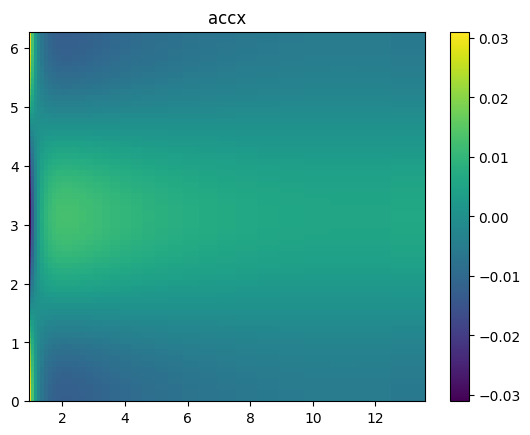

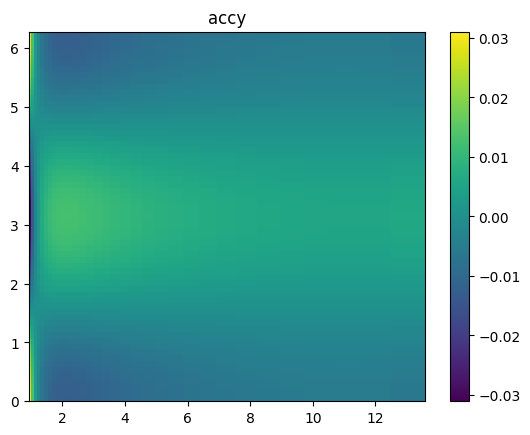

In [13]:
fig, ax = plt.subplots()
pcm = ax.pcolormesh(Rplot.to_value("au"), PHIplot, accx.to_value("cm/s2"))
ax.set_title("accx")
cbar = fig.colorbar(pcm)

fig, ax = plt.subplots()
pcm = ax.pcolormesh(Rplot.to_value("au"), PHIplot, accx.to_value("cm/s2"))
ax.set_title("accy")
cbar = fig.colorbar(pcm)

## 4. Convert to polar coordinates

In [14]:
accr = accx * np.cos(PHI) + accy * np.sin(PHI)

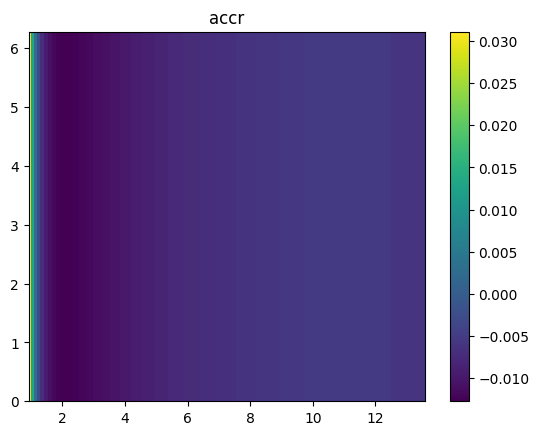

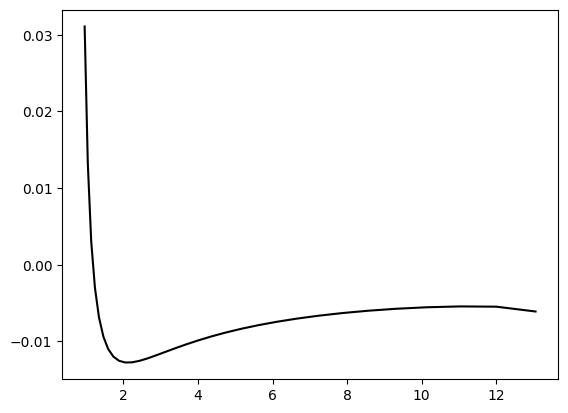

In [15]:
fig, ax = plt.subplots()
pcm = ax.pcolormesh(Rplot.to_value("au"), PHIplot, accr.to_value("cm/s2"))
ax.set_title("accr")
cbar = fig.colorbar(pcm)

fig, ax = plt.subplots()
ax.plot(R[:,0].to_value("au"), accr[:,1].to_value("cm/s2"), color="k")

## 5. Compare to the values from the code

In [16]:
r_code, gr_code = ld.gas.vars2D.avg("a_sg_rad", 0)
r_code = r_code.to_value("au")
gr_code = gr_code.to_value("cm/s2")

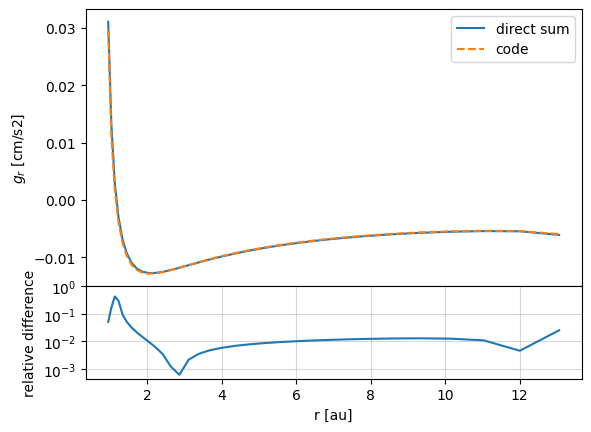

In [24]:
gr_direct = accr[:,1].to_value("cm/s2")
r_direct = R[:,0].to_value("au")

fig, axs = plt.subplots(2,1,height_ratios=[3,1], sharex=True)
fig.subplots_adjust(hspace=0)
ax = axs[0]
ax.plot(r_direct, gr_direct, label="direct sum")
ax.plot(r_code, gr_code, ls="--", label="code")
ax.set_xlabel("r [au]")
ax.set_ylabel("$g_r$ [cm/s2]")
ax.legend()

ax = axs[1]
diff = np.abs(gr_code/gr_direct - 1)
ax.plot(r_code, diff)
ax.set_yscale("log")
ax.set_xlabel("r [au]")
ax.set_ylabel("relative difference")
ax.grid(alpha=0.5)
ax.set_yticks([1e-3, 1e-2, 1e-1, 1]);

## Pass fail test

There seems to be a systematic deviation between the two cases.
This is likely due to the difference between the direct summation and Fourier methods.

For a threshold, we take the values from the region r>2au. Further in the crossing of zero and strong gradient makes a slight shift in positions a large relative error.
The maximum relative deviation outside 2au is 0.02298.
We therefore take a value around this as threshold.
For 32x64, a threshold = 0.0254 lets the test pass.

Below is the plot for the 128x256 case.

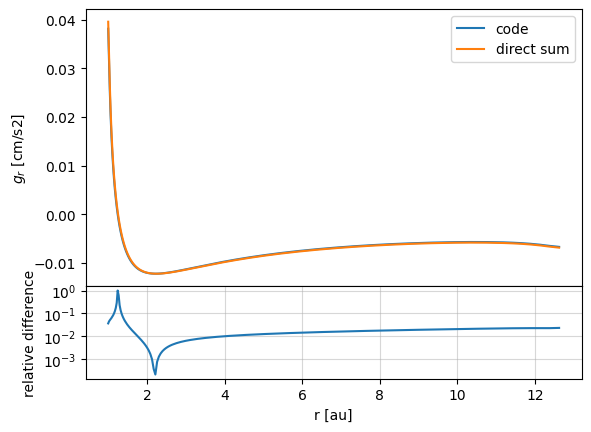

In [23]:
threshold = 0.054
diff_test = diff[r_code > 2]
max_diff = np.max(diff_test)
if max_diff < threshold:
    print(f"Test passed with max rel diff outside 2 au = {max_diff:.2e}")
else:
    print(f"Test failed with max rel diff outside 2 au = {max_diff:.2e}")


Test passed with max rel diff outside 2 au = 2.53e-02
